# Is using Softmax for calibrating SVM-RBF classifier better than the `libsvm` method (pairwise)?


`libsvm`: Wu, Ting-Fan, Chih-Jen Lin, and Ruby C. Weng. [Probability estimates for multi-class classification by pairwise coupling](http://www.jmlr.org/papers/volume5/wu04a/wu04a.pdf). Journal of Machine Learning Research 5.Aug (2004).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from livelossplot import PlotLossesKeras

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
def generate_data(n_samples):
    X, y = make_classification(n_samples=n_samples, n_features=3, n_redundant=0, n_informative=3,
                                 n_clusters_per_class=1, n_classes=5)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X, y, X_train, X_test, y_train, y_test

# plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
#            s=25, edgecolor='k')

In [3]:
def calc_cross_entropy(X_train, y_train, X_test, y_test):
    xe = {}
    
    clf = SVC(kernel='rbf', C=1, probability=True)
    clf.fit(X_train, y_train)
    
    xe['acc'] = clf.score(X_test, y_test)
    xe['libsvm'] = -np.mean([log_probs[index] for log_probs, index in zip(clf.predict_log_proba(X_test), y_test)])
    

    model = Sequential()
    model.add(Dense(5, input_dim=10, activation='softmax'))

    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(clf._dense_decision_function(X_train), to_categorical(y_train), epochs=50, validation_split=0.1,
             callbacks=[EarlyStopping()], verbose=0)
    
    t = np.log(model.predict_proba(clf._dense_decision_function(X_test)))

    xe['softmax'] = -np.mean([log_probs[index] for log_probs, index in zip(t, y_test)])
    
    return xe

In [4]:
xes = []
for n_samples in tqdm_notebook(10 ** np.arange(2, 5)):
    for _ in tqdm_notebook(range(20)):
        _, _, X_train, X_test, y_train, y_test = generate_data(n_samples)
        xe = calc_cross_entropy(X_train, y_train, X_test, y_test)
        xe['n_samples'] = n_samples
        xes.append(xe)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


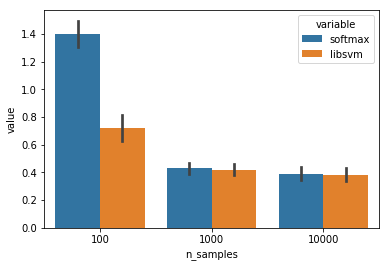

In [5]:
df = pd.DataFrame(xes)[['n_samples', 'softmax', 'libsvm']]
df_long = pd.melt(df, id_vars=['n_samples'], value_vars=['softmax', 'libsvm'])
sns.barplot(x='n_samples', y='value', hue='variable', 
            data=df_long)

# Verdict: No!
# `libsvm` method is better!
### However, softmax is differentiable, in case that is what we need.